# Test effect of different sample sizes

In [2]:
import os
import pandas as pd
import sys
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle
from matplotlib.legend import Legend
from matplotlib import gridspec
import matplotlib
import seaborn as sns
import umap
from pathlib import Path

In [3]:
from evaluation_functions import nn, sil
from preprocessing_functions import calc_zscore, create_padded_data

In [4]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures", "sample_sizes")

if (not os.path.isdir(FIGURES)):
    os.mkdir(FIGURES)
    print("Generated directory at: ",FIGURES)
else:
    print("Directory already present")

Directory already present


In [5]:
dftype = "balanced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, 'df_focal_'+dftype+'.pkl'))
spec_df.shape

(1148, 34)

## Loop

In [6]:
class_tab_dict = {}

In [7]:
k=5
n_times = 5
class_sizes = [10,20,30,50,75,100,140,160]

n_class_table = np.zeros((len(class_sizes)*n_times,2+7+7+1))

for i, class_size in enumerate(class_sizes*n_times):
    
    #print('Processing N=',class_size)
    
    df = spec_df.copy()
    
    labelcounts = pd.DataFrame(df['call_lable'].value_counts())
    subsets = []
    for label in labelcounts.index:
        subsets.append(df[df.call_lable == label].sample(n=class_size, replace=False))##, random_state=2204))
    df = pd.concat(subsets, axis=0)
    df.reset_index(inplace=True)
    #print(df.shape)

    # UMAP
    specs = df.spectrograms # now 2D arrays n_mels+time_frames(varying)
    specs = [calc_zscore(s) for s in specs]
    data = create_padded_data(specs)
    
    #print("Running UMAP...")
    
    reducer = umap.UMAP(low_memory=True, n_components = 3, min_dist=0, random_state=2204)
    embedding = reducer.fit_transform(data)
    
    #print("Evaluating...")
    
    # EVAL
    labels = df.call_lable.values
    calltypes = sorted(list(set(labels)))

    nn_stats = nn(embedding, labels, k)
    n_class_table[i,0] = nn_stats.get_Snorm()
    n_class_table[i,1] = nn_stats.get_S()

    n_class_table[i,2:9] = nn_stats.get_ownclass_Snorm() 
    n_class_table[i,9:16] = nn_stats.get_ownclass_S()

    sil_stats = sil(embedding, labels)
    n_class_table[i,16] = sil_stats.get_avrg_score()


    #print("Snorm:",round(n_class_table[i,0],4))
    #print("S:",round(n_class_table[i,1],4))
    #print("SIL:", round(silhouette_avg))


In [8]:
n_class_table_df = pd.DataFrame(n_class_table)
n_class_table_df['N per class'] = class_sizes*n_times

class_tab_dict['balanced_means'] = n_class_table_df.groupby('N per class').mean()
class_tab_dict['balanced_stds'] = n_class_table_df.groupby('N per class').std()

## Viz

In [9]:
# with error bars
dftype = 'balanced'
#dftype = 'reduced'

plot_type = 'norm'
plot_type = 'abs'

if dftype=='balanced':
    plot_x_lab = "N per class"
    means_df = class_tab_dict['balanced_means']
    stds_df = class_tab_dict['balanced_stds']
    xax = class_sizes
else:
    plot_x_lab = "N total"
    means_df = class_tab_dict['reduced_means']
    stds_df = class_tab_dict['reduced_stds']
    xax = [x*df_focal.shape[0] for x in fracts]

if plot_type=='norm':
    from_c = 2
    to_c = 9
    mean_c = 0
    mean_ylab = "Embedding score Snorm"
    all_ylab = "Same-class neighborhood probability Pnorm"
    plot_ylim_l = -0.5
    plot_ylim_u = 3
else:
    from_c = 9
    to_c = 16
    mean_c = 1
    mean_ylab = "Embedding score S"
    all_ylab = "Same-class neighborhood probability P"
    plot_ylim_l = 0
    plot_ylim_u = 100

In [10]:
dftype = dftype+'mod'

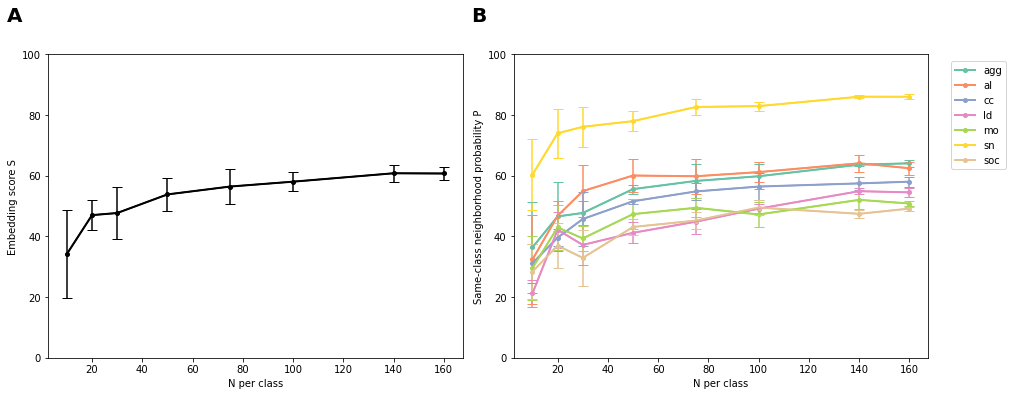

In [28]:
# with error bars
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
#fig = plt.figure(figsize= (7, 8))
sub_table = np.asarray(means_df.iloc[:,from_c:to_c])
sub_table_stds = np.asarray(stds_df.iloc[:,from_c:to_c])

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

plt.plot(xax, means_df.iloc[:,mean_c], marker='o',linewidth=2, markersize=4, color = 'black',label='mean')
plt.errorbar(xax, means_df.iloc[:,mean_c], yerr=sub_table_stds[:,1], capsize=5,color='black')

#lgd = plt.legend(bbox_to_anchor=(1.2, 0.86), loc='right')

plt.ylim(plot_ylim_l,plot_ylim_u)
plt.ylabel(mean_ylab)
plt.xlabel(plot_x_lab)


plt.subplot(1, 2, 2)
#fig = plt.figure(figsize= (7, 8))
sub_table = np.asarray(means_df.iloc[:,from_c:to_c])
sub_table_stds = np.asarray(stds_df.iloc[:,from_c:to_c])

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))


for i,call_type in enumerate(calltypes):
    plt.plot(xax, sub_table[:,i], marker='o',linewidth=2, markersize=4, color = color_dict[call_type],label=call_type)
    plt.errorbar(xax, sub_table[:,i], yerr=sub_table_stds[:,i], capsize=5, color = color_dict[call_type])

lgd = plt.legend(bbox_to_anchor=(1.2, 0.8), loc='right')

plt.ylim(plot_ylim_l,plot_ylim_u)
plt.ylabel(all_ylab)
plt.xlabel(plot_x_lab)

plt.figtext(0.01,1.05, "A", size=20, weight='bold')
plt.figtext(0.47,1.05, "B", size=20, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(os.path.sep,FIGURES,'samplesizes'+str(n_times)+'_times_'+plot_type+'_'+dftype+'.png'), bbox_inches='tight', facecolor="white")
#plt.savefig(os.path.join(os.path.sep,FIGURES,'samplesizes'+str(n_times)+'_times_'+plot_type+'_'+dftype+'.png'), bbox_extra_artists=(lgd,), bbox_inches='tight', facecolor="white")

# For imbalanced

In [29]:
dftype = "reduced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, 'df_focal_'+dftype+'.pkl'))
spec_df.shape

(6430, 34)

In [30]:
k=5
n_times = 5
fracts = [0.01, 0.02,0.05,0.1,0.2,0.3,0.5,1]
n_fract_table = np.zeros((len(fracts)*n_times,2+7+7))

for i, fract in enumerate(fracts*n_times):
    
    print('Processing N=',fract)

    # subset spec_df
    labelcounts = pd.DataFrame(df['call_lable'].value_counts())
    subsets = []
    for label in labelcounts.index:
        subsets.append(spec_df[spec_df.call_lable == label].sample(frac=fract, replace=False)) #, random_state=2204))
    
    df = pd.concat(subsets, axis=0)

    # UMAP
    specs = [calc_zscore(s) for s in df.spectrograms]
    data = create_padded_data(specs)
    
    reducer = umap.UMAP(low_memory=True, n_components = 3, min_dist=0, random_state=2204)
    embedding = reducer.fit_transform(data)

    # EVAL
    labels = df.call_lable.values
    calltypes = sorted(list(set(labels)))
    
    nn_stats = nn(embedding, labels, k)
    
    n_fract_table[i,0] = nn_stats.get_Snorm()
    n_fract_table[i,1] = nn_stats.get_S()

    n_fract_table[i,2:9] = nn_stats.get_ownclass_Snorm()
    n_fract_table[i,9:16] = nn_stats.get_ownclass_S()

Processing N= 0.01
Processing N= 0.02
Processing N= 0.05
Processing N= 0.1
Processing N= 0.2
Processing N= 0.3
Processing N= 0.5
Processing N= 1
Processing N= 0.01
Processing N= 0.02
Processing N= 0.05
Processing N= 0.1
Processing N= 0.2
Processing N= 0.3
Processing N= 0.5
Processing N= 1
Processing N= 0.01
Processing N= 0.02
Processing N= 0.05
Processing N= 0.1
Processing N= 0.2
Processing N= 0.3
Processing N= 0.5
Processing N= 1
Processing N= 0.01
Processing N= 0.02
Processing N= 0.05
Processing N= 0.1
Processing N= 0.2
Processing N= 0.3
Processing N= 0.5
Processing N= 1
Processing N= 0.01
Processing N= 0.02
Processing N= 0.05
Processing N= 0.1
Processing N= 0.2
Processing N= 0.3
Processing N= 0.5
Processing N= 1


In [39]:
n_fract_table_df = pd.DataFrame(n_fract_table)
n_fract_table_df['N per class'] = fracts*n_times

class_tab_dict['reduced_means'] = n_fract_table_df.groupby('N per class').mean()
class_tab_dict['reduced_stds'] = n_fract_table_df.groupby('N per class').std()

In [56]:
# with error bars
#dftype = 'balanced'
dftype = 'reduced'

plot_type = 'norm'
plot_type = 'abs'

if dftype=='balanced':
    plot_x_lab = "N per class"
    means_df = class_tab_dict['balanced_means']
    stds_df = class_tab_dict['balanced_stds']
    xax = class_sizes
else:
    plot_x_lab = "N total"
    means_df = class_tab_dict['reduced_means']
    stds_df = class_tab_dict['reduced_stds']
    xax = [x*spec_df.shape[0] for x in fracts]

if plot_type=='norm':
    from_c = 2
    to_c = 9
    mean_c = 0
    mean_ylab = "Embedding score Snorm"
    all_ylab = "Same-class neighborhood probability Pnorm"
    plot_ylim_l = -0.5
    plot_ylim_u = 3
else:
    from_c = 9
    to_c = 16
    mean_c = 1
    mean_ylab = "Embedding score S"
    all_ylab = "Same-class neighborhood probability P"
    plot_ylim_l = 0
    plot_ylim_u = 100

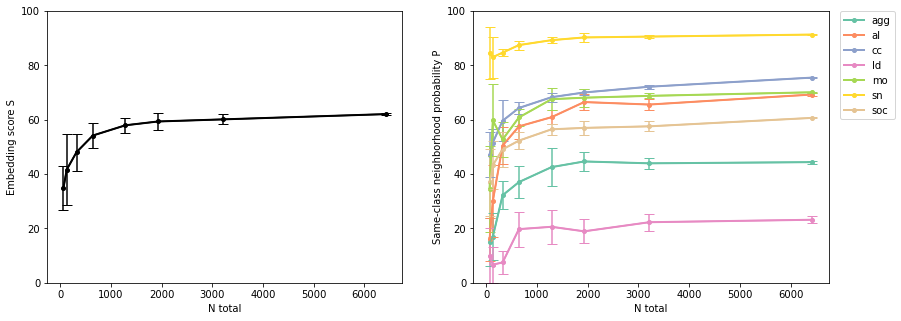

In [57]:
# with error bars
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
#fig = plt.figure(figsize= (7, 8))

sub_table = np.asarray(means_df.iloc[:,from_c:to_c])
sub_table_stds = np.asarray(stds_df.iloc[:,from_c:to_c])

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

plt.plot(xax, means_df.iloc[:,mean_c], marker='o',linewidth=2, markersize=4, color = 'black',label='mean')
plt.errorbar(xax, means_df.iloc[:,mean_c], yerr=sub_table_stds[:,1], capsize=5,color='black')

#lgd = plt.legend(bbox_to_anchor=(1.2, 0.86), loc='right')

plt.ylim(plot_ylim_l,plot_ylim_u)
plt.ylabel(mean_ylab)
plt.xlabel(plot_x_lab)


plt.subplot(1, 2, 2)
#fig = plt.figure(figsize= (7, 8))
sub_table = np.asarray(means_df.iloc[:,from_c:to_c])
sub_table_stds = np.asarray(stds_df.iloc[:,from_c:to_c])

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))


for i,call_type in enumerate(calltypes):
    plt.plot(xax, sub_table[:,i], marker='o',linewidth=2, markersize=4, color = color_dict[call_type],label=call_type)
    plt.errorbar(xax, sub_table[:,i], yerr=sub_table_stds[:,i], capsize=5, color = color_dict[call_type])

lgd = plt.legend(bbox_to_anchor=(1.2, 0.8), loc='right')

plt.ylim(plot_ylim_l,plot_ylim_u)
plt.ylabel(all_ylab)
plt.xlabel(plot_x_lab)

plt.figtext(0.01,1.05, "A", size=20, weight='bold')
plt.figtext(0.47,1.05, "B", size=20, weight='bold')

plt.tight_layout()

plt.savefig(os.path.join(os.path.sep,FIGURES,'samplesizes'+str(n_times)+'_times_'+plot_type+'_'+dftype+'.png'), bbox_inches='tight', facecolor="white")